In [1]:
from IPython.display import HTML
HTML('''<script>
code_show = true;

function code_toggle() {
    if (code_show) {
        $('div.input').hide();
    } else {
        $('div.input').show();
    }
    code_show = !code_show
}
$(document).ready(code_toggle);
</script>
<font size='2'>
    Code in this notebook is hidden by default. Click <a href='javascript:code_toggle()'>here</a> to toggle code cells.
</font>
<hr>''')

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri
import rpy2.robjects
import h5py
import collections
import scipy.sparse as sp_sparse
import tables

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
import rpy2.robjects.numpy2ri
import rpy2.robjects
rpy2.robjects.numpy2ri.activate()
%load_ext rpy2.ipython
%reload_ext rpy2.ipython
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.3 anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

In [5]:
from sinfo import sinfo
sinfo()

-----
anndata2ri	0.1.dev66+3fe0c7d
gprofiler 	1.0.0
h5py      	2.9.0
matplotlib	3.1.1
numpy     	1.16.4
pandas    	0.24.2
rpy2      	3.0.5
scanpy    	1.4.3
scipy     	1.3.0
seaborn   	0.9.0
tables    	3.5.2
-----
IPython   	7.6.1
jupyter_client	5.3.3
jupyter_core	4.5.0
jupyterlab	1.0.4
notebook  	6.0.1
-----
Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 14:38:56) [Clang 4.0.1 (tags/RELEASE_401/final)]
Darwin-16.7.0-x86_64-i386-64bit
4 logical CPU cores, i386
-----
Session information updated at 2019-11-27 21:15


Load in the data

In [9]:
adataa = sc.read_10x_h5('/Users/Vyom/data/SB04_05_matrices_including_raw/SB04_AA_filtered_feature_bc_matrix.h5', genome=None, gex_only=True)


reading /Users/Vyom/data/SB04_05_matrices_including_raw/SB04_AA_filtered_feature_bc_matrix.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:02.16)


In [10]:
adataa.var_names_make_unique()

In [11]:
adata1 = adataa.copy()

Filter out genes 

In [13]:
# Checking the total size of the data set
adata1.shape

(4147, 28692)

In [14]:
#Filter genes that are not expressed in many genes:
print('Total number of genes: {:d}'.format(adata1.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata1, min_cells=5)
print('Number of genes after cell filter: {:d}'.format(adata1.n_vars))

Total number of genes: 28692
filtered out 13320 genes that are detected in less than 5 cells
Number of genes after cell filter: 15372


In [15]:
adata1.obs['n_counts'] = adata1.X.sum(1)
adata1.obs['log_counts'] = np.log(adata1.obs['n_counts'])
adata1.obs['n_genes'] = (adata1.X > 0).sum(1)



Identify number genes and counts and conduct log transformation of the counts

In [16]:
sc.pp.filter_cells(adata1, min_counts=200)
sc.pp.filter_genes(adata1, min_cells=3)



In [17]:
adata1.shape

(4147, 15372)

### Define gene sets for QC metrics

In [18]:

mito_genes = [name for name in adata1.var_names if name.startswith('mt-')]
Rpl_genes = [name for name in adata1.var_names if name.startswith('Rpl')]
Rps_genes = [name for name in adata1.var_names if name.startswith('Rps')]
ribo_genes = Rpl_genes + Rps_genes
# for each cell compute fraction of counts in mito genes vs. all genes
# the ".A1" is only necessary, as X is sparse - it transform to a dense array after summing
adata1.obs['percent_mito'] = np.sum(
    adata1[:, mito_genes].X, axis=1) / np.sum(adata1.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata1.obs['n_counts'] = np.sum(adata1.X, axis=1)
#Count IEG genes and calculate percentage per cell
#adata.obs['percent_IEG'] = np.sum(
#    adata[:, IEG].X, axis=1) / np.sum(adata.X, axis=1)
#Calculate the percent Rpl genes per cell
adata1.obs['percent_Rpl'] = np.sum(
    adata1[:, Rpl_genes].X, axis=1) / np.sum(adata1.X, axis=1)
#Calculate the percent Ribo genes per cell
adata1.obs['percent_ribo'] = np.sum(
    adata1[:, ribo_genes].X, axis=1) / np.sum(adata1.X, axis=1)
#Calculate the percent cell cycle genes per cell
#adata.obs['percent_cell_cycle'] = np.sum(
#    adata[:, cell_cycle].X, axis=1) / np.sum(adata.X, axis=1)
#sc.tl.score_genes(adata,cell_cycle,score_name='cell_cycle')


# add the total counts per cell as observations-annotation to adata

... storing 'feature_types' as categorical
... storing 'genome' as categorical


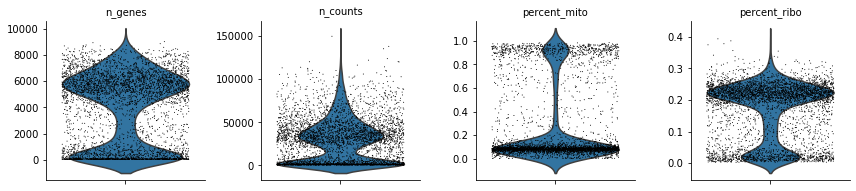

In [19]:
axs = sc.pl.violin(adata1, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'],
                   jitter=0.4, multi_panel=True)

/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


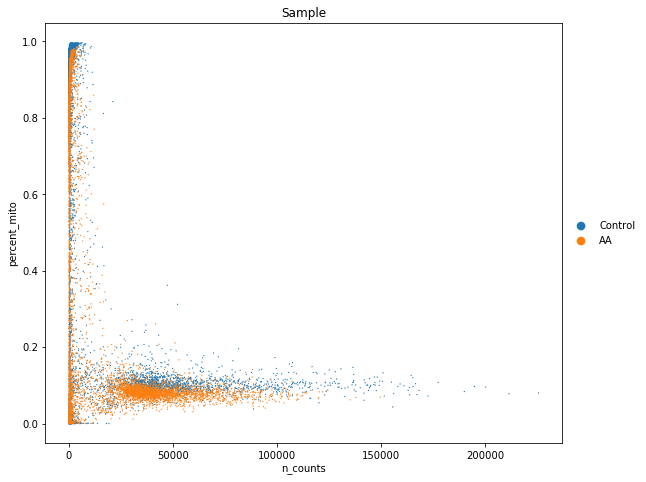

/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


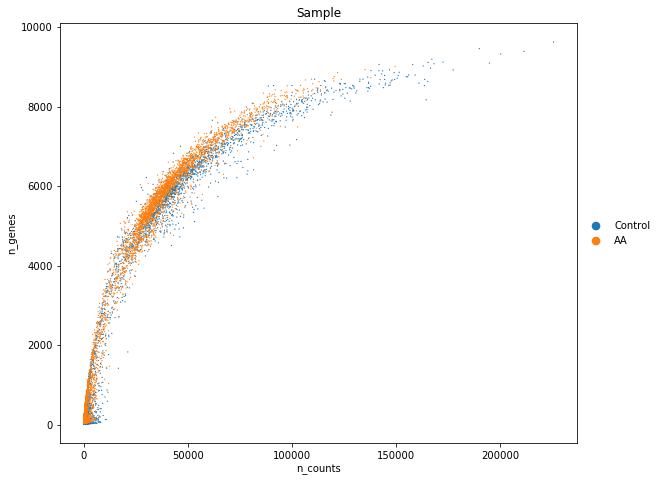

In [17]:
ax = sc.pl.scatter(adata1, x='n_counts', y='percent_mito', color='Sample')
ax = sc.pl.scatter(adata1, x='n_counts', y='n_genes', color='Sample')


In [20]:
n_gene_cap = 10000
n_counts_min = 200
percent_mito_cap = 0.15

print("Cells with n_genes < " + str(n_gene_cap) + ":", len(adata1[adata1.obs['n_genes'] < n_gene_cap]))
print("Cells with n_genes > " + str(n_gene_cap) + ":", len(adata1[adata1.obs['n_genes'] > n_gene_cap]))
print()
print("Cells with n_counts_min < " + str(n_counts_min) + ":", len(adata1[adata1.obs['n_counts'] < n_counts_min]))
print("Cells with n_counts_min > " + str(n_counts_min) + ":", len(adata1[adata1.obs['n_counts'] > n_counts_min]))
print()
print("Cells with percent_mito < " + str(percent_mito_cap) + ":", len(adata1[adata1.obs['percent_mito'] < percent_mito_cap]))
print("Cells with percent_mito > " + str(percent_mito_cap) + ":", len(adata1[adata1.obs['percent_mito'] > percent_mito_cap]))

Cells with n_genes < 10000: 4147
Cells with n_genes > 10000: 0

Cells with n_counts_min < 200: 0
Cells with n_counts_min > 200: 4147

Cells with percent_mito < 0.15: 3035
Cells with percent_mito > 0.15: 1112


In [21]:
print("Number of cells before filtering:",len(adata1))
adata1 = adata1[adata1.obs['n_genes'] < n_gene_cap, :]
adata1 = adata1[adata1.obs['percent_mito'] < percent_mito_cap, :]
adata1 = adata1[adata1.obs['n_counts'] > n_counts_min, :]
print("Number of cells after filtering:",len(adata1))

Number of cells before filtering: 4147
Number of cells after filtering: 3035


In [22]:
print("Number of cells before filtering:",len(adata1))
#adata1 = adata1[adata1.obs['n_genes'] > 1000, :]
print("Number of cells after filtering:",len(adata1))

Number of cells before filtering: 3035
Number of cells after filtering: 3035


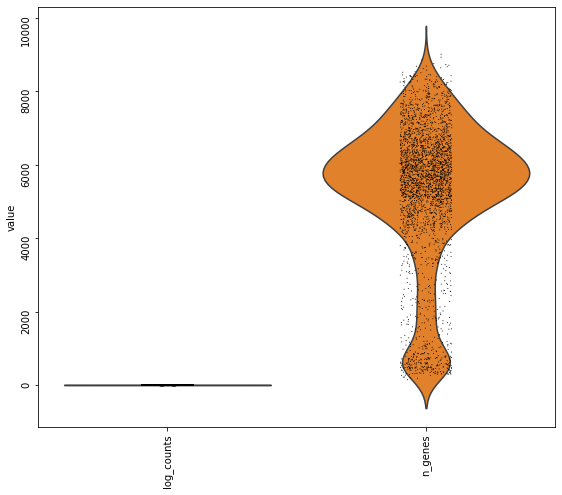

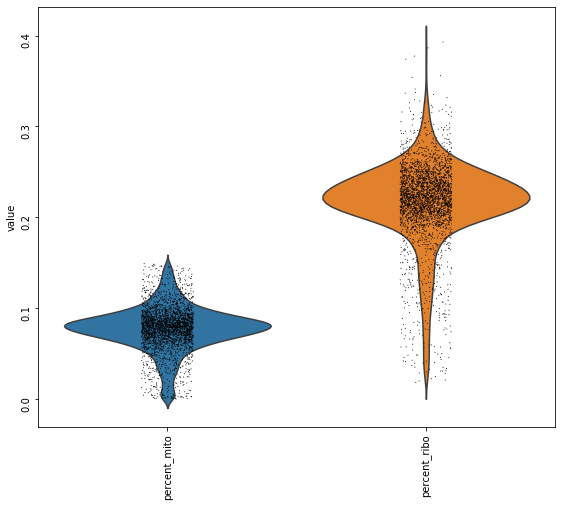

In [24]:
sc.pl.violin(adata1,  keys=['log_counts','n_genes'], rotation=90)
sc.pl.violin(adata1,  keys=['percent_mito','percent_ribo'], rotation=90)

In [25]:
marker_genes = dict()
marker_genes['S'] = ['S100a6']
marker_genes['T'] = ['Fabp1']
marker_genes['X'] = ['Ctnnb1']
marker_genes['Wnt'] = ['Lgr5', 'Rnf43', 'Lrp6', 'Axin1', 'Apc', 'Gsk3b', 'Ctnnb1', 'Tcf7l2',  'Fbxw7']
marker_genes['B'] = ['Apc']
marker_genes['d'] = ['Defa24']
marker_genes['K'] = ['Myc']
marker_genes['l'] = ['Lgr5']
marker_genes['Wnt1'] = ['Lgr5', 'Rnf43', 'Ctnnb1','Ccnd1','Id2', 'Ephb2', 'Olfm4', 'Slc12a2','Ascl2', 'Ephb2', 'Cldn4','Rnf11', 'Rnf186','Id2','Acaa2','Hmgcs2'   ]
marker_genes['l'] = ['Lgr5']
marker_genes['h'] = ['Hopx']
marker_genes['si'] = ['Siah1a']
marker_genes['bcatenin'] = ['Lgr5', 'Rnf43', 'Ctnnb1','Ccnd1','Id2', 'Ephb2', 'Olfm4', 'Slc12a2','Ascl2', "Hopx",'Ephb2', 'Cldn4','Id2'   ]
marker_genes['A'] = ['Id2']


# Normilization

After cells are filtered the next step will be normalization. This step is conducted to account for any variability. This is done calculating size factors: estimating cell-specific factors that should be proportional to the true number of molecules(cause some genes have more base pairs than others)

Calculate clusters at a low resolution in order to get an input the size factor estimation.

In [26]:
#Perform a clustering for scran normalization in clusters
adata1_pp = adata1.copy()
sc.pp.normalize_per_cell(adata1_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata1_pp)
sc.pp.pca(adata1_pp, n_comps=15)
sc.pp.neighbors(adata1_pp)
sc.tl.louvain(adata1_pp, key_added='groups', resolution=0.7)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:03.48)
computing neighbors
    using 'X_pca' with n_pcs = 15


/Applications/miniconda3/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../Applications/miniconda3/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Applications/miniconda3/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../Applications/miniconda3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Applications/miniconda3/lib/python3.7/site-packages/numba/compiler.py:734: Nu

    finished (0:00:03.63) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.31) --> found 10 clusters and added
    'groups', the cluster labels (adata.obs, categorical)


Preprocess data by assuming that all size factors are equal

In [27]:
#Preprocess variables for scran normalization
input_groups = adata1_pp.obs['groups']
data_mat = adata1.X.T

Calculate size factors

In [28]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [29]:
del adata1_pp

Visualize the estimated size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


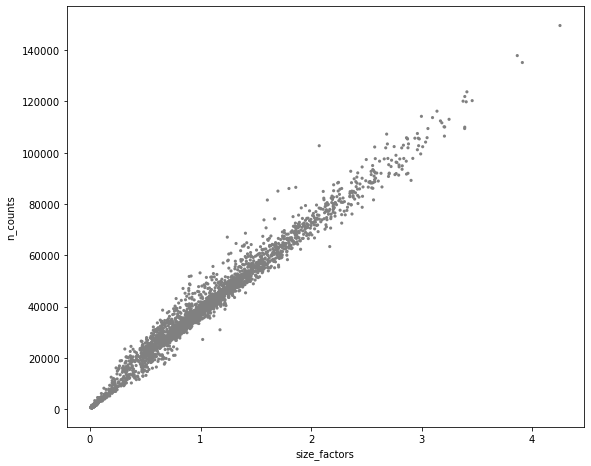

/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


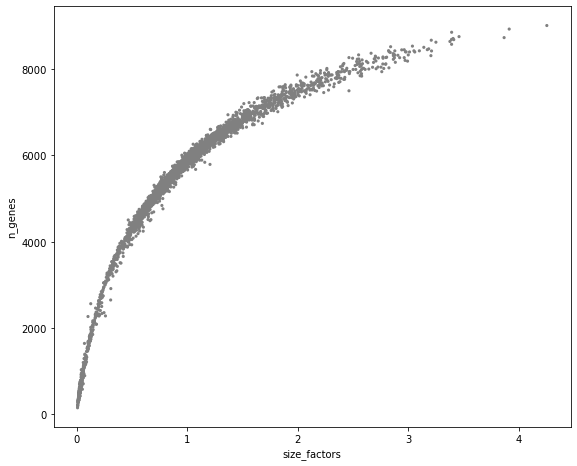

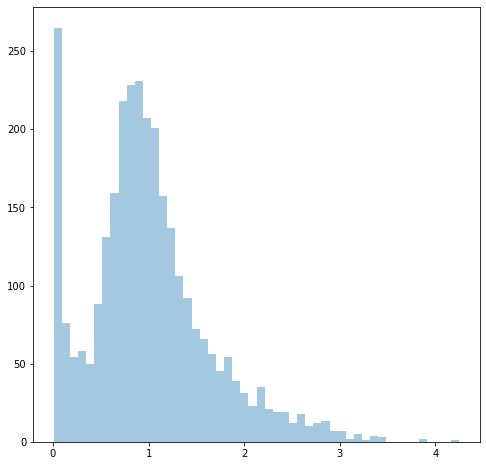

In [30]:
adata1.obs['size_factors'] = size_factors

sc.pl.scatter(adata1, 'size_factors', 'n_counts')
sc.pl.scatter(adata1, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

copy the raw count data in a separate AnnData object. This allows us to use methods downstream that require this data as input.

In [31]:
#Keep the count data in a counts layer
adata1.layers["counts"] = adata1.X.copy()

Log transform the data. This allows the log transformed data to follow or nearly follow a normal distribution and have reduced skewness

In [32]:
#Normalize adata 
adata1.X /= adata1.obs['size_factors'].values[:,None]
sc.pp.log1p(adata1)

In [33]:
del adata1.layers['counts']

In [34]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata1.raw = adata1

extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. 

In [37]:
import scipy
adata1.X = scipy.sparse.csr_matrix(adata1.X)
sc.pp.highly_variable_genes(adata1, flavor='cell_ranger', n_top_genes=10000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata1.var['highly_variable'])))

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 10000


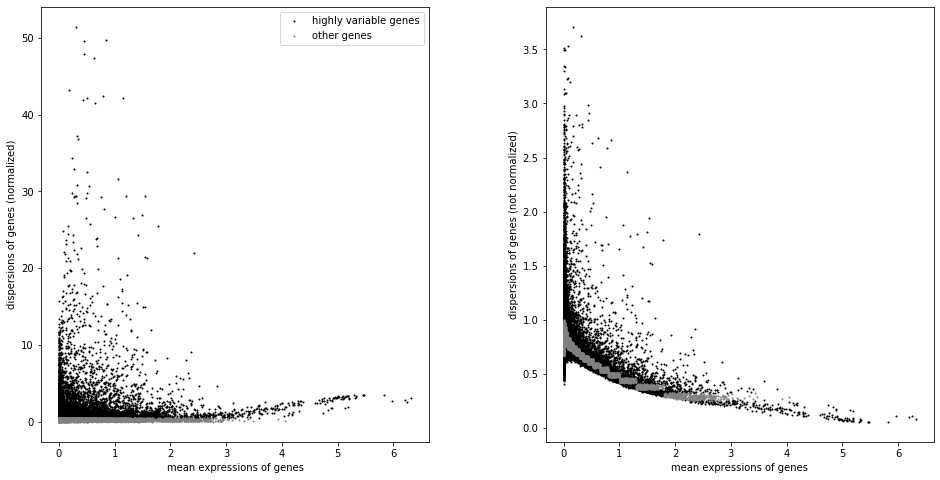

In [38]:
sc.pl.highly_variable_genes(adata1)

# Visualization, clustering, sub clustering, marker genes & cluster annotation

The next step is visualizing. Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. Visualization will ease the computational burdan of downstream analysis.

In [39]:
# Calculate the visualizations
sc.pp.pca(adata1, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata1)

sc.tl.tsne(adata1, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata1)
sc.tl.diffmap(adata1)
sc.tl.draw_graph(adata1)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:09.89)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00.57) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:27.08) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:07.77) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9975183  0.9906648  0.98862875 0.9849242  0.981043
     0.9605381  0.9594818  0.94852394 0.94445807 0.9395863  0.9342009
     0.9316954  0.9275245  0.9190713 ]
    finished (0:00:00.09) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', ei

Below multiple visulization methods are dispayed. However for the remainder of the analysis the Umap method will be used. This is because in a Umap visulization data points are spread out on the plot showing several clusters
and connections between clusters can be readily identified


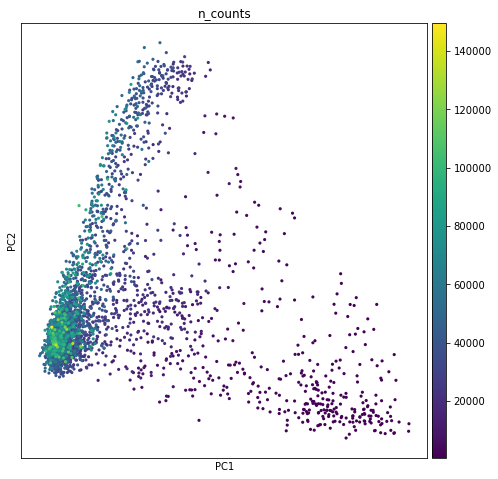

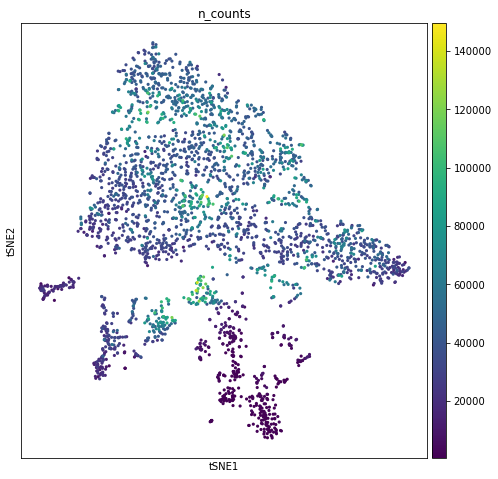

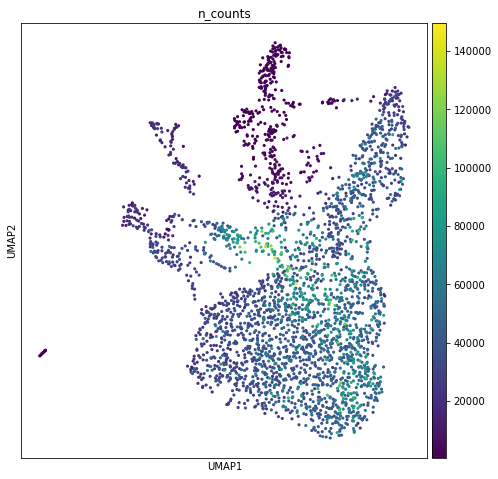

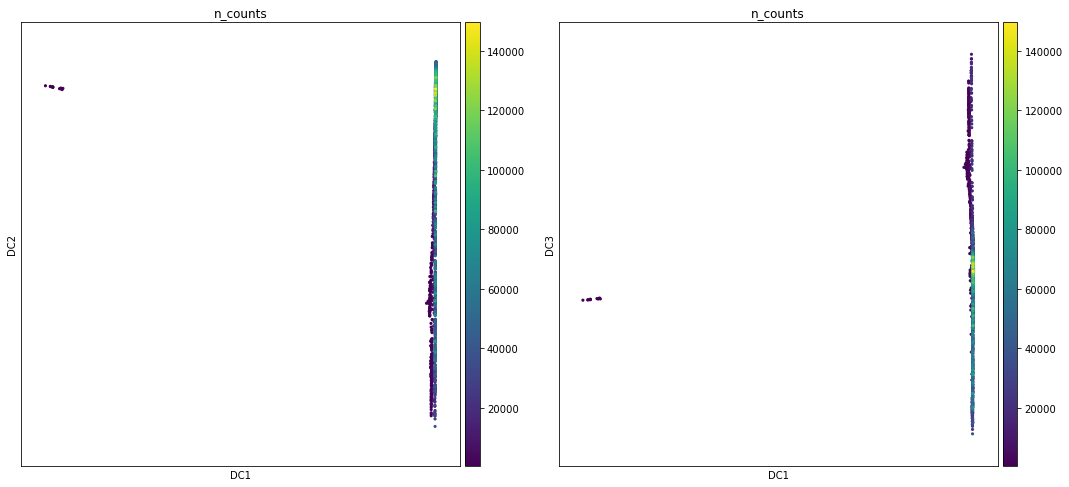

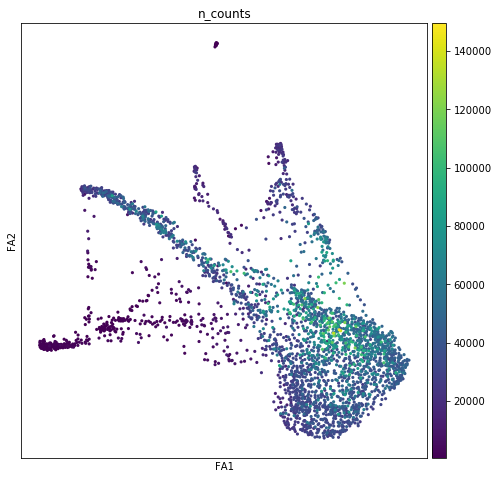

In [40]:
sc.pl.pca_scatter(adata1, color='n_counts')
sc.pl.tsne(adata1, color='n_counts')
sc.pl.umap(adata1, color='n_counts')
sc.pl.diffmap(adata1, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata1, color='n_counts')

To understand the data, we must identify cell types and states present. This can be done by clustering the data. I perform modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells. Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph.

In [47]:
sc.tl.louvain(adata1, key_added='louvain_r1')
sc.tl.louvain(adata1, resolution=0.45, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.45) --> found 13 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.39) --> found 7 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical)


In [48]:
adata1.obs['louvain_r0.5'].value_counts()

0    903
1    855
2    429
3    262
4    257
5    256
6     73
Name: louvain_r0.5, dtype: int64

Visualize the clustering and how this is reflected by different technical covariates

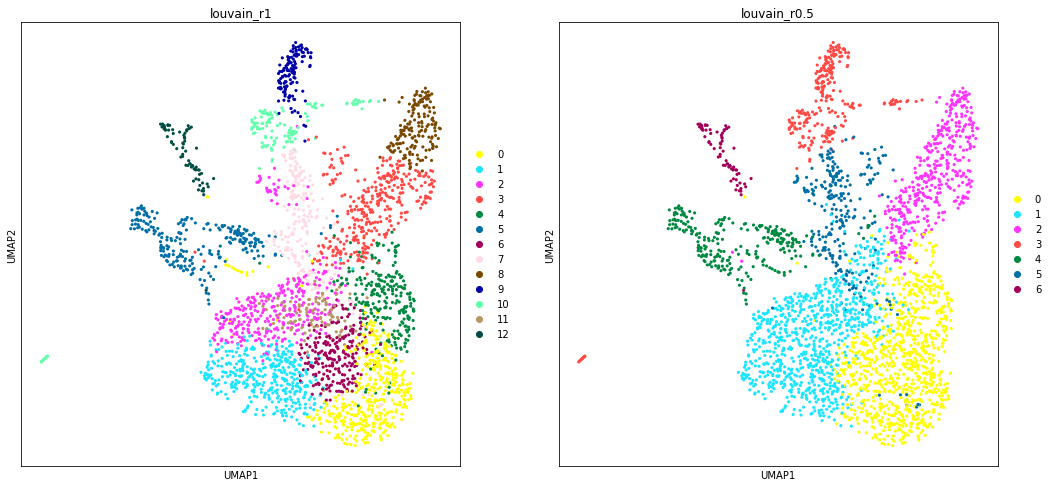

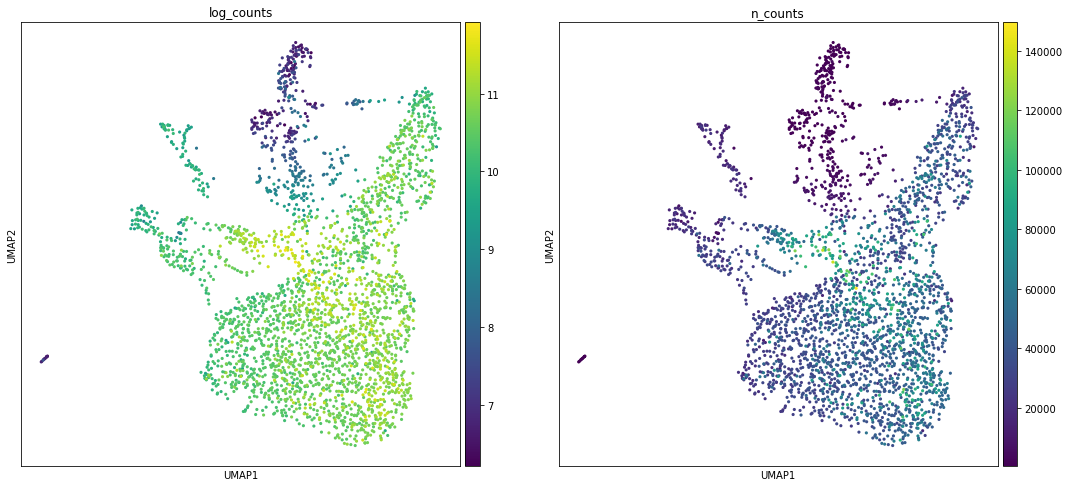

ValueError: The passed `color` Sample is not a valid observation annotation or variable name. Valid observation annotation keys are: Index(['n_counts', 'log_counts', 'n_genes', 'percent_mito', 'percent_Rpl',
       'percent_ribo', 'size_factors', 'louvain_r1', 'louvain_r0.5'],
      dtype='object')

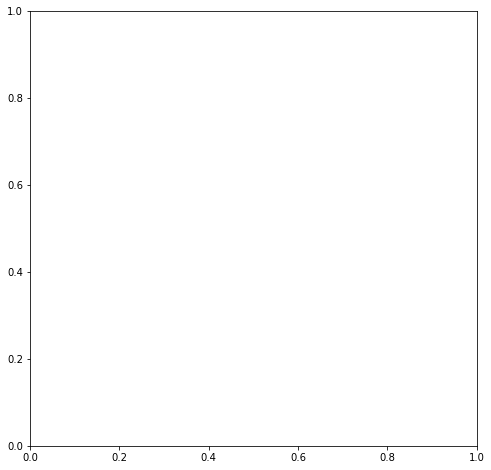

In [49]:
sc.pl.umap(adata1, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata1, color=['log_counts', 'n_counts'])
sc.pl.umap(adata1, color=['Sample'])


Define a nice colour map for gene expression

In [51]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

Below are maps that display the expression of genes of interest, the scale on the right displays the expression of the genes 

Cluster annotation. In order to annotate the clusters expression of marker genes for intestinal epithelium regions  is compared to other reigions. Below the marker genes are defined

In [70]:
#Known marker genes:
marker_genes = dict()
marker_genes['Stem'] = ['Lgr5', 'Ascl2', 'Slc12a2', 'Axin2', 'Olfm4', 'Gkn3']
marker_genes['Enterocyte (Proximal)'] = ['Gsta1','Rbp2','Adh6a','Apoa4','Reg3a','Creb3l3','Cyp3a13','Cyp2d26','Ms4a10','Ace','Aldh1a1','Rdh7','H2-Q2', 'Hsd17b6','Gstm3','Gda','Apoc3','Gpd1','Fabp1','Slc5a1','Mme','Cox7a1','Gsta4','Lct','Khk','Mttp','Xdh','Sult1b1', 'Treh','Lpgat1','Dhrs1','Cyp2c66','Ephx2','Cyp2c65','Cyp3a25','Slc2a2','Ugdh','Gstm6','Retsat','Ppap2a','Acsl5', 'Cyb5r3','Cyb5b','Ckmt1','Aldob','Ckb','Scp2','Prap1']
marker_genes['Enterocyte (Distal)'] = ['Tmigd1','Fabp6','Slc51b','Slc51a','Mep1a','Fam151a','Naaladl1','Slc34a2','Plb1','Nudt4','Dpep1','Pmp22','Xpnpep2','Muc3','Neu1','Clec2h','Phgr1','2200002D01Rik','Prss30','Cubn','Plec','Fgf15','Crip1','Krt20','Dhcr24','Myo15b','Amn','Enpep','Anpep','Slc7a9','Ocm','Anxa2','Aoc1','Ceacam20','Arf6','Abcb1a','Xpnpep1','Vnn1','Cndp2','Nostrin','Slc13a1','Aspa','Maf','Myh14']
marker_genes['Goblet'] = ['Agr2', 'Fcgbp', 'Tff3', 'Clca1', 'Zg16', 'Tpsg1', 'Muc2', 'Galnt12', 'Atoh1', 'Rep15', 'S100a6', 'Pdia5', 'Klk1', 'Pla2g10', 'Spdef', 'Lrrc26', 'Ccl9', 'Bace2', 'Bcas1', 'Slc12a8', 'Smim14', 'Tspan13', 'Txndc5', 'Creb3l4', 'C1galt1c1', 'Creb3l1', 'Qsox1', 'Guca2a', 'Scin', 'Ern2', 'AW112010', 'Fkbp11', 'Capn9', 'Stard3nl', 'Slc50a1', 'Sdf2l1', 'Hgfa', 'Galnt7', 'Hpd', 'Ttc39a', 'Tmed3', 'Pdia6', 'Uap1', 'Gcnt3', 'Tnfaip8', 'Dnajc10', 'Ergic1', 'Tsta3', 'Kdelr3', 'Foxa3', 'Tpd52', 'Tmed9', 'Spink4', 'Nans', 'Cmtm7', 'Creld2', 'Tm9sf3', 'Wars', 'Smim6', 'Manf', 'Oit1', 'Tram1', 'Kdelr2', 'Xbp1', 'Serp1', 'Vimp', 'Guk1', 'Sh3bgrl3', 'Cmpk1', 'Tmsb10', 'Dap', 'Ostc', 'Ssr4', 'Sec61b', 'Pdia3', 'Gale', 'Klf4', 'Krtcap2', 'Arf4', 'Sep15', 'Ssr2', 'Ramp1', 'Calr', 'Ddost']
marker_genes['Paneth'] = ['Gm15284', 'AY761184', 'Defa17', 'Gm14851', 'Defa22', 'Defa-rs1', 'Defa3', 'Defa24', 'Defa26', 'Defa21', 'Lyz1', 'Gm15292', 'Mptx2', 'Ang4']
marker_genes['Enteroendocrine'] = ['Chgb', 'Gfra3', 'Cck', 'Vwa5b2', 'Neurod1', 'Fev', 'Aplp1', 'Scgn', 'Neurog3', 'Resp18', 'Trp53i11', 'Bex2', 'Rph3al', 'Scg5', 'Pcsk1', 'Isl1', 'Maged1', 'Fabp5', 'Celf3', 'Pcsk1n', 'Fam183b', 'Prnp', 'Tac1', 'Gpx3', 'Cplx2', 'Nkx2-2', 'Olfm1', 'Vim', 'Rimbp2', 'Anxa6', 'Scg3', 'Ngfrap1', 'Insm1', 'Gng4', 'Pax6', 'Cnot6l', 'Cacna2d1', 'Tox3', 'Slc39a2', 'Riiad1']
marker_genes['Tuft'] = ['Alox5ap', 'Lrmp', 'Hck', 'Avil', 'Rgs13', 'Ltc4s', 'Trpm5', 'Dclk1', 'Spib', 'Fyb', 'Ptpn6', 'Matk', 'Snrnp25', 'Sh2d7', 'Ly6g6f', 'Kctd12', '1810046K07Rik', 'Hpgds', 'Tuba1a', 'Pik3r5', 'Vav1', 'Tspan6', 'Skap2', 'Pygl', 'Ccdc109b', 'Ccdc28b', 'Plcg2', 'Ly6g6d', 'Alox5', 'Pou2f3', 'Gng13', 'Bmx', 'Ptpn18', 'Nebl', 'Limd2', 'Pea15a', 'Tmem176a', 'Smpx', 'Itpr2', 'Il13ra1', 'Siglecf', 'Ffar3', 'Rac2', 'Hmx2', 'Bpgm', 'Inpp5j', 'Ptgs1', 'Aldh2', 'Pik3cg', 'Cd24a', 'Ethe1', 'Inpp5d', 'Krt23', 'Gprc5c', 'Reep5', 'Csk', 'Bcl2l14', 'Tmem141', 'Coprs', 'Tmem176b', '1110007C09Rik', 'Ildr1', 'Galk1', 'Zfp428', 'Rgs2', 'Inpp5b', 'Gnai2', 'Pla2g4a', 'Acot7', 'Rbm38', 'Gga2', 'Myo1b', 'Adh1', 'Bub3', 'Sec14l1', 'Asah1', 'Ppp3ca', 'Agt', 'Gimap1', 'Krt18', 'Pim3', '2210016L21Rik', 'Tmem9', 'Lima1', 'Fam221a', 'Nt5c3', 'Atp2a3', 'Mlip', 'Vdac3', 'Ccdc23', 'Tmem45b', 'Cd47', 'Lect2', 'Pla2g16', 'Mocs2', 'Arpc5', 'Ndufaf3']
marker_genes['TA'] = ['Stmn1', 'Tubb5']
marker_genes['EP(early)'] = ['Slc16a1']
marker_genes['EP(late)'] = ['Ccnb1','Cdc20','Cenpa','Cdkn3','Cdc25c','Ccnb2','Kif22','Ube2c','Sapcd2','Rbp7','Ccna2','Aurka','Cdkn2d','Kif23','Nek2','Birc5','Plk1']

In [53]:
marker_genes['S'] = ['S100a6']
marker_genes['T'] = ['Fabp1']
marker_genes['X'] = ['S100a4']
marker_genes['Wnt'] = ['Lgr5', 'Rnf43', 'Lrp6', 'Axin1', 'Apc', 'Gsk3b', 'Ctnnb1', 'Tcf7l2',  'Fbxw7']
marker_genes['B'] = ['Apc']



Identify the cell type that associates with each cluster using marker genes idenitfied-through lit review- above 

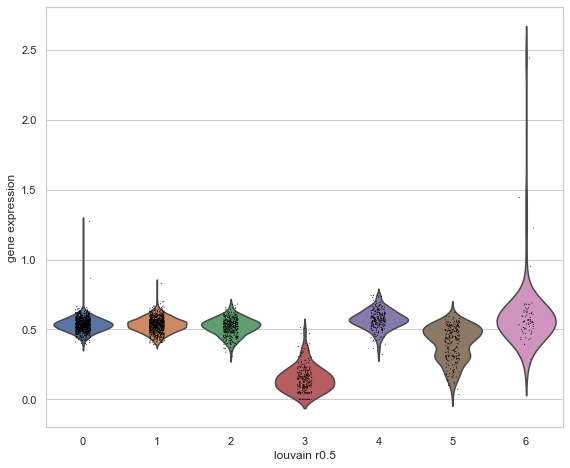

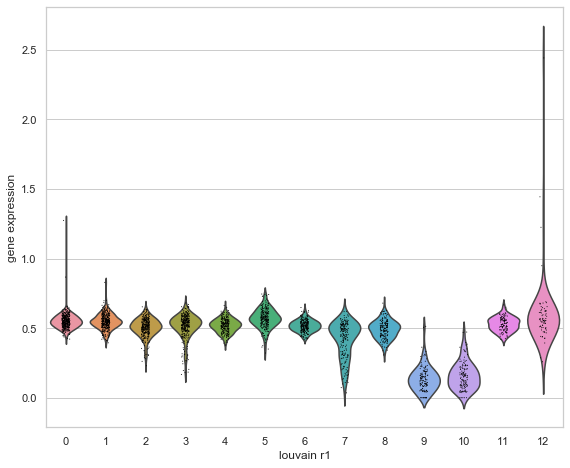

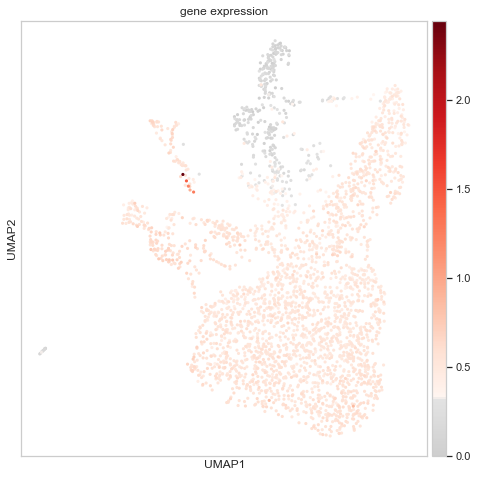

ValueError: not enough values to unpack (expected 2, got 1)

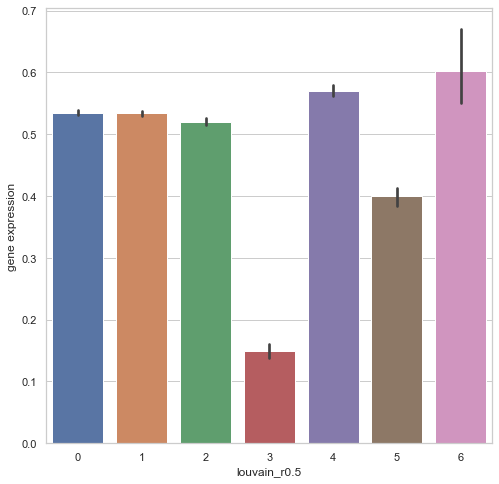

In [73]:
# Check expression of enterocyte markers
#Collate all enterocyte markers and get the gene IDs in the data set
ids_entprox = np.in1d(adata1.var_names, marker_genes['Tuft'])
ids_entdist = np.in1d(adata1.var_names, marker_genes['Tuft'])
ids_ent = np.logical_or(ids_entprox, ids_entdist)

#Calculate the mean expression of enterocyte markers
adata1.obs['gene expression'] = adata1.X[:,ids_ent].mean(1)

#Plot enterocyte expression
sc.pl.violin(adata1, 'gene expression', groupby='louvain_r0.5')
sc.pl.violin(adata1, 'gene expression', groupby='louvain_r1')
sc.pl.umap(adata1, color='gene expression', color_map=mymap)

sb.set(style="whitegrid")
ax = sb.barplot(x="louvain_r0.5", y="gene expression", data=adata1.obs)
ax = (ax.set(ylim=(0,)))

plt.show()

In [74]:
adata1.rename_categories('louvain_r0.5', ['Stem', 'TA', 'Enterocyte','Goblet' ,'Paneth', 'EP','Enteroendocrine'])


In [75]:
adata1.obs['Cell Type'] = adata1.obs['louvain_r0.5']

In [76]:
adata1.obs

,n_counts,log_counts,n_genes,percent_mito,percent_Rpl,percent_ribo,size_factors,louvain_r1,louvain_r0.5,gene expression,Cell Type
AAACCCAGTACAAACA-1,35463.0,10.476245,5505,0.091165,0.133237,0.242563,0.843124,3,Enterocyte,0.521003,Enterocyte
AAACCCAGTTGTCAGT-1,24955.0,10.124829,4755,0.121939,0.112683,0.206812,0.595764,3,Enterocyte,0.478144,Enterocyte
AAACGAAGTCGAGATG-1,25932.0,10.163233,5051,0.104697,0.113219,0.206347,0.707451,2,TA,0.516739,TA
AAACGCTGTAACCCGC-1,5708.0,8.649624,2248,0.121058,0.137351,0.243518,0.167026,7,EP,0.311833,EP
AAACGCTGTCTAGTGT-1,92049.0,11.430077,8008,0.059479,0.114504,0.207705,2.707912,4,Stem,0.521670,Stem
AAAGAACAGCCGTTGC-1,10355.0,9.245225,2741,0.062385,0.139450,0.249831,0.218364,5,Paneth,0.538494,Paneth
AAAGAACCACACCAGC-1,52405.0,10.866757,6887,0.082397,0.149795,0.276310,1.411400,0,Stem,0.526032,Stem
AAAGAACGTACGGCAA-1,67076.0,11.113582,6297,0.106670,0.138589,0.248017,1.242415,3,Enterocyte,0.586638,Enterocyte
AAAGAACTCACATCAG-1,1123.0,7.023759,621,0.008014,0.127337,0.234194,0.040665,10,Goblet,0.208311,Goblet
AAAGAACTCCGCGGAT-1,42405.0,10.655022,5398,0.109775,0.104257,0.186818,0.826144,8,Enterocyte,0.499547,Enterocyte


In [78]:
adata1.obs['louvain_r0.5'].value_counts()


Stem               903
TA                 855
Enterocyte         429
Goblet             262
Paneth             257
EP                 256
Enteroendocrine     73
Name: louvain_r0.5, dtype: int64

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

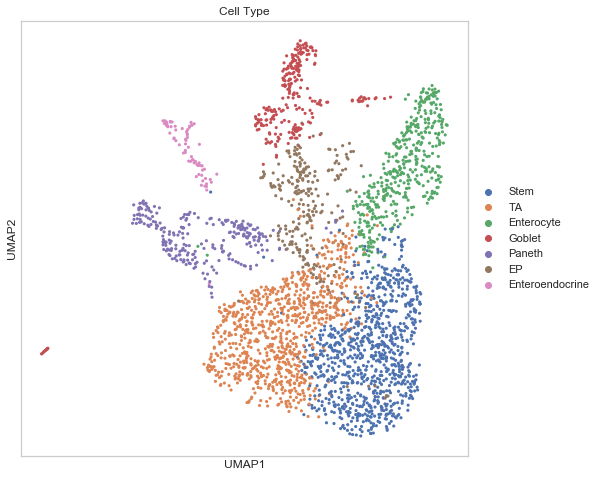

In [79]:
sc.pl.umap(adata1, color='Cell Type', use_raw=False, color_map=mymap)


louvain_r0.5,Stem,TA,Enterocyte,Goblet,Paneth,EP,Enteroendocrine
Cell Type,,,,,,,
Stem,903,0,0,0,0,0,0
TA,0,855,0,0,0,0,0
Enterocyte,0,0,429,0,0,0,0
Goblet,0,0,0,262,0,0,0
Paneth,0,0,0,0,257,0,0
EP,0,0,0,0,0,256,0
Enteroendocrine,0,0,0,0,0,0,73


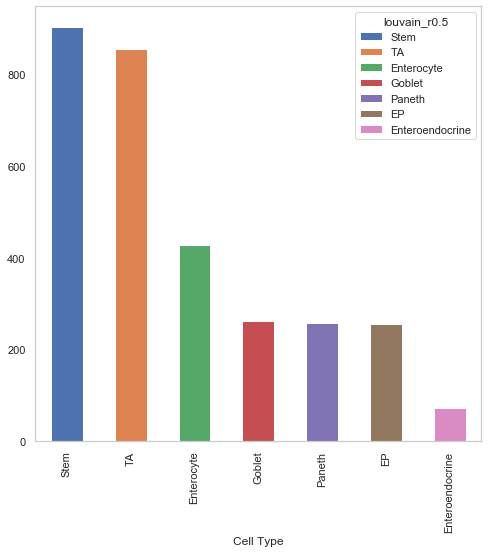

In [81]:
var1 = 'Cell Type'
var2 = 'louvain_r0.5'

df = adata1.obs.loc[:, [var1,var2]]
df_pivot = df.pivot_table(index=var1, columns=var2, aggfunc=len, fill_value=0)
import seaborn as sns
df_pivot
df_pivot.plot(kind='bar', stacked=True, grid=False)

df = adata1.obs.loc[:, [var1,var2]]
df_pivot = df.pivot_table(index=var1, columns=var2, aggfunc=len, fill_value=0)
df_pivot

In [54]:
adata1.obs

,Sample,n_counts,log_counts,n_genes,percent_mito,percent_Rpl,percent_ribo,size_factors,louvain_r1,louvain_r0.5,gene expression,Cell Type
AAACCCAAGAGTCTTC-1-Control,Control,49945.0,10.818678,6310,0.090159,0.128021,0.232976,1.492933,11,Stem,1.046203,Stem
AAACCCAAGGTGCCAA-1-Control,Control,1855.0,7.525640,923,0.019407,0.143396,0.264690,0.047315,13,TA,0.029915,TA
AAACCCAGTCTAATCG-1-Control,Control,1487.0,7.304516,817,0.002017,0.163416,0.286483,0.040655,1,TA,0.029915,TA
AAACCCATCCATACTT-1-Control,Control,82507.0,11.320639,7556,0.104997,0.125771,0.233132,2.558188,0,Stem,1.346082,Stem
AAACCCATCGGTGTAT-1-Control,Control,121198.0,11.705181,8404,0.100637,0.149103,0.275549,3.683520,0,Stem,1.699009,Stem
AAACGAAGTCAAGCGA-1-Control,Control,1067.0,6.972606,552,0.138707,0.138707,0.257732,0.025845,1,TA,0.029915,TA
AAACGCTGTCCTGGTG-1-Control,Control,239.0,5.476463,193,0.004184,0.096234,0.259414,0.006732,1,TA,0.029915,TA
AAAGAACAGACATACA-1-Control,Control,51393.0,10.847258,6400,0.090499,0.131419,0.245014,1.522294,0,Stem,1.012224,Stem
AAAGAACTCCCATAAG-1-Control,Control,38767.0,10.565325,5530,0.115149,0.141976,0.258932,1.049354,2,Stem,0.797279,Stem
AAAGAACTCTAAACGC-1-Control,Control,24968.0,10.125350,4912,0.112023,0.120835,0.225208,0.779144,2,Stem,0.630631,Stem


Rename clusters 

In [82]:
#Categories to rename
adata1.obs['louvain_r0.5'].cat.categories

Index(['Stem', 'TA', 'Enterocyte', 'Goblet', 'Paneth', 'EP',
       'Enteroendocrine'],
      dtype='object')

In [83]:
adata1.obs['louvain_r0.5'].value_counts()

Stem               903
TA                 855
Enterocyte         429
Goblet             262
Paneth             257
EP                 256
Enteroendocrine     73
Name: louvain_r0.5, dtype: int64

Visualize new clusters

In [84]:
adata1.obs

,n_counts,log_counts,n_genes,percent_mito,percent_Rpl,percent_ribo,size_factors,louvain_r1,louvain_r0.5,gene expression,Cell Type
AAACCCAGTACAAACA-1,35463.0,10.476245,5505,0.091165,0.133237,0.242563,0.843124,3,Enterocyte,0.521003,Enterocyte
AAACCCAGTTGTCAGT-1,24955.0,10.124829,4755,0.121939,0.112683,0.206812,0.595764,3,Enterocyte,0.478144,Enterocyte
AAACGAAGTCGAGATG-1,25932.0,10.163233,5051,0.104697,0.113219,0.206347,0.707451,2,TA,0.516739,TA
AAACGCTGTAACCCGC-1,5708.0,8.649624,2248,0.121058,0.137351,0.243518,0.167026,7,EP,0.311833,EP
AAACGCTGTCTAGTGT-1,92049.0,11.430077,8008,0.059479,0.114504,0.207705,2.707912,4,Stem,0.521670,Stem
AAAGAACAGCCGTTGC-1,10355.0,9.245225,2741,0.062385,0.139450,0.249831,0.218364,5,Paneth,0.538494,Paneth
AAAGAACCACACCAGC-1,52405.0,10.866757,6887,0.082397,0.149795,0.276310,1.411400,0,Stem,0.526032,Stem
AAAGAACGTACGGCAA-1,67076.0,11.113582,6297,0.106670,0.138589,0.248017,1.242415,3,Enterocyte,0.586638,Enterocyte
AAAGAACTCACATCAG-1,1123.0,7.023759,621,0.008014,0.127337,0.234194,0.040665,10,Goblet,0.208311,Goblet
AAAGAACTCCGCGGAT-1,42405.0,10.655022,5398,0.109775,0.104257,0.186818,0.826144,8,Enterocyte,0.499547,Enterocyte


Here we do a compositional analysis 

In [85]:
#Create new Anndata object for use in MAST with non-batch corrected data as before
adata1_test = adata1.copy()
adata1_test.X = np.squeeze(np.asarray(adata1.raw.X))
#adata1_test.X = np.squeeze(np.asarray(adata1.raw.X))
adata1_test.obs['n_genes'] = (adata1_test.X > 0).sum(1) # recompute number of genes expressed per cell

In [86]:
#Subsetting to relevant clusters
clusters_to_include = [g for g in adata1.obs['Cell Type'].cat.categories if (g.startswith('Stem') or g.startswith('TA') or g.startswith('Enterocyte') or g.startswith('Goblet') or g.startswith('Enteroendocrine') or g.startswith('EP(s'))]
adata_ent = adata1[np.isin(adata1.obs['Cell Type'], clusters_to_include),:].copy()

#Subset to highly variable genes
sc.pp.highly_variable_genes(adata_ent, flavor='cell_ranger', n_top_genes=10000, subset=True)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:08.84)


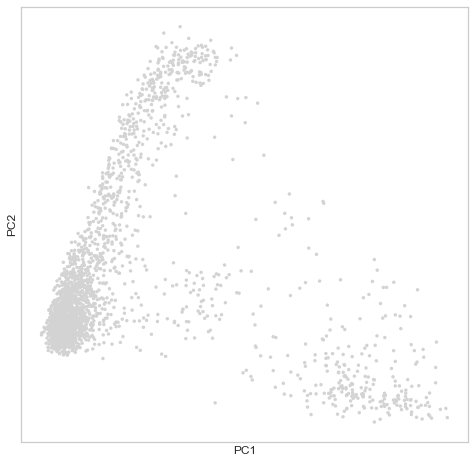

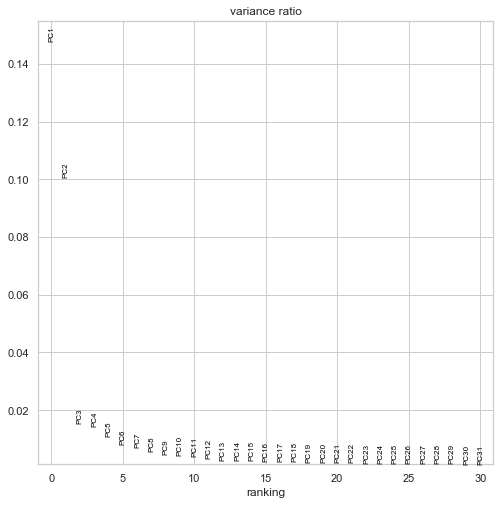

In [87]:
#Recalculating PCA for subset
sc.pp.pca(adata_ent, svd_solver='arpack')
sc.pl.pca(adata_ent)
sc.pl.pca_variance_ratio(adata_ent)

In [88]:
adata_ent.obsm['X_pca'] = adata_ent.obsm['X_pca'][:,0:7]


The first method of this analysis uses the slingshot package in R. The package 'anndata2ri' is responsible for converting the anndata object to a single cell experiment. The graph below displays the trajectory structure if the structure starts with the stem cell cluster and displays the differentiation process.

In [90]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

The next method for trajectory interface is monocle. Monocle is a more populer form of trajectory analysis as it works very well with multiple trajectory interfaces. Here I used monocle to confirm that the trajectories from slingshot.

In [92]:
#Preprocessing for monocle
adata1.layers["counts"] = adata1.X.copy()
data_mat_mon = adata1.layers['counts'].T
var_mon=adata1.var.copy()
obs_mon=adata1.obs.copy()

In [107]:
%%R -i data_mat_mon -i obs_mon -i var_mon

#Set up the CellDataSet data structure
pd <- AnnotatedDataFrame(data = obs_mon)
fd <- AnnotatedDataFrame(data = var_mon)
colnames(data_mat_mon) <- rownames(pd)
rownames(data_mat_mon) <- rownames(fd)
ie_regions_cds <- newCellDataSet(cellData=data_mat_mon, phenoData=pd, featureData=fd, expressionFamily=negbinomial.size())

#Normalize the count data
ie_regions_cds <- estimateSizeFactors(ie_regions_cds)

#Calculate dispersions to filter for highly variable genes
ie_regions_cds <- estimateDispersions(ie_regions_cds)


#Filter for Stem, EP, TA, and Enterocytes
cell_types = as.character(pData(ie_regions_cds)$louvain_r0.5)
cell_mask = rep(FALSE, length(cell_types))
cells_to_keep = c("Stem", "TA", "Ent","Goblet","Pan")
for (item in cells_to_keep) {cell_mask = cell_mask | startsWith(cell_types, item)}
print("Number of cells after filtering:")
print(sum(cell_mask))
print("")

#Filter highly variable genes from our analysis
hvg_mask = fData(ie_regions_cds)$highly_variable
ie_regions_cds <- ie_regions_cds[hvg_mask, cell_mask]
print("check1")
#Do dimensionality reduction
ie_regions_cds <- reduceDimension(ie_regions_cds, norm_method = 'vstExprs', reduction_method='DDRTree', verbose = F, max_components = 7)
print("check2")
#Run for the first time to get the ordering
ie_regions_cds <- orderCells(ie_regions_cds)
print("check3")
#Find the correct root state the corresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$louvain_r0.5)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))
print("check4")
#Run a second time to get the correct root state that overlaps with Stem cells
ie_regions_cds <- orderCells(ie_regions_cds, root_state=root_name)


[1] "Number of cells after filtering:"
[1] 2779
[1] ""
[1] "check1"
[1] "check2"
[1] "check3"
[1] "check4"


The chart below displays the the linages that diverge from stem cells. Stem cells differentiate into distal enterocytes and then proximal enterocytes.

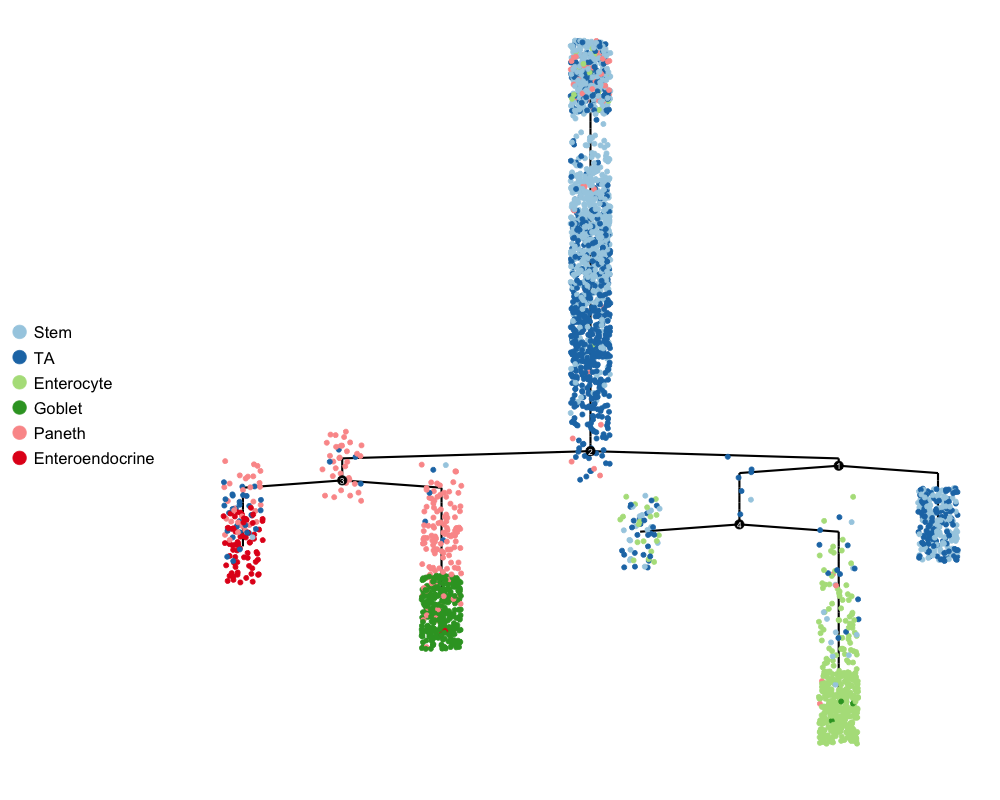

In [108]:
%%R -w 1000 -h 800

#Get a nice colour map
custom_colour_map = brewer.pal(length(unique(pData(ie_regions_cds)$louvain_r0.5)),'Paired')

#Find the correct root state that coresponds to the 'Stem' cluster
tab1 <- table(pData(ie_regions_cds)$State, pData(ie_regions_cds)$louvain_r0.5)
id = which(colnames(tab1) == 'Stem')
root_name = names(which.max(tab1[,id]))

# Visualize with our cluster labels
options(repr.plot.width=5, repr.plot.height=4)
plot_complex_cell_trajectory(ie_regions_cds, color_by = 'louvain_r0.5', show_branch_points = T, 
                             cell_size = 2, cell_link_size = 1, root_states = c(root_name)) +
scale_size(range = c(0.2, 0.2)) +
theme(legend.position="left", legend.title=element_blank(), legend.text=element_text(size=rel(1.5))) +
guides(colour = guide_legend(override.aes = list(size=6))) + 
scale_color_manual(values = custom_colour_map)

This chart displays the trajectory as the pseudotime advances

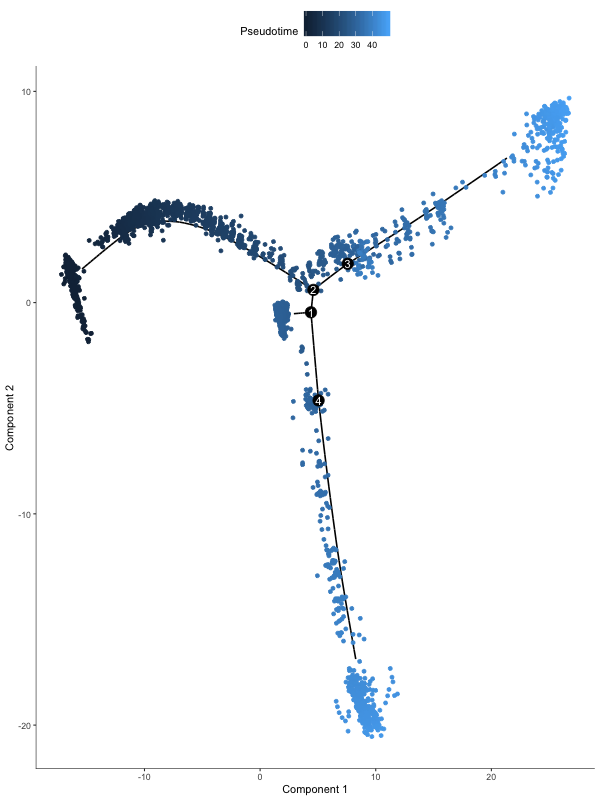

In [109]:
%%R -w 600 -h 800

#Visualize pseudotime found
options(repr.plot.width=5, repr.plot.height=4)
plot_cell_trajectory(ie_regions_cds, color_by="Pseudotime")

Below are the trajectories displayed in the format of a diffusion map. I include Diffusion Pseudotime in the analysis to further support the found trajectories. The benefits of a diffusion map are as follows: shows connections between regions of higher density; very clear trajectories are suggested, but clusters are less clear; each diffusion component extracts heterogeneity in a different part of the data

In [110]:
sc.pp.neighbors(adata_ent)
sc.tl.diffmap(adata_ent)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished (0:00:00.50) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.998795   0.995993   0.991772   0.9842362  0.97712505
     0.97312975 0.97108364 0.96709645 0.9596936  0.9487372  0.94512427
     0.9397826  0.9381054  0.9357356 ]
    finished (0:00:00.11) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


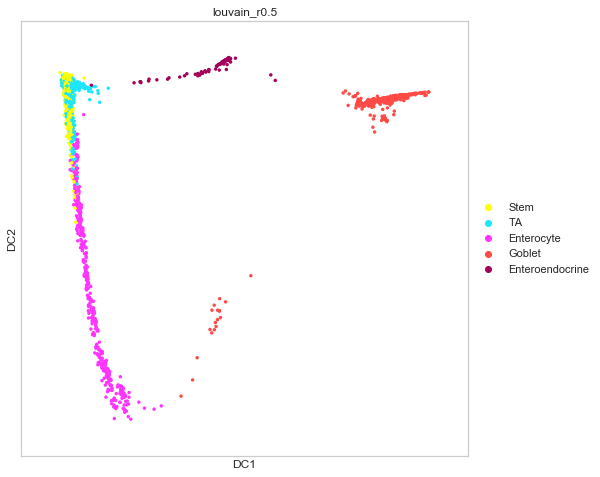

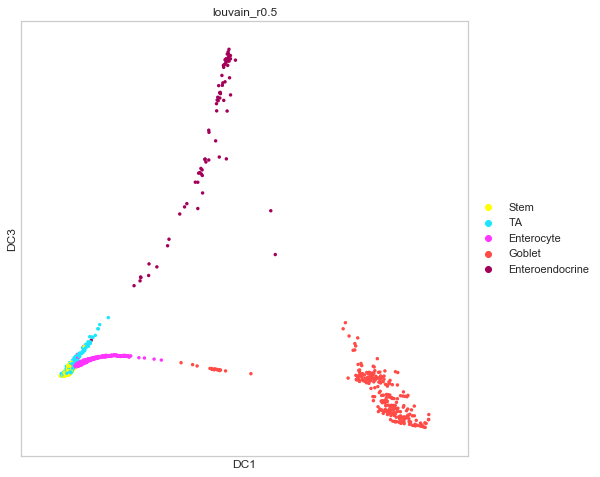

In [111]:
sc.pl.diffmap(adata_ent, components='1,2', color='louvain_r0.5')
sc.pl.diffmap(adata_ent, components='1,3', color='louvain_r0.5')